## Web Scraping: Cotización Cedears Argentina
---
https://iol.invertironline.com/mercado/cotizaciones/argentina/cedears/todos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from datetime import date
import pymysql
import warnings

# Deshabilitamos las advertencias de compatibilidad de lectura SQL:
warnings.filterwarnings('ignore')

### Funciones Scraper:
---

#### FUNCION extraer_tabla():

Esta función se encarga de extraer la tabla principal desde la url indicada:

In [2]:
def extraer_tabla():
    url = 'https://iol.invertironline.com/mercado/cotizaciones/argentina/cedears/todos'
    r = requests.get(url)
    s = BeautifulSoup(r.text, 'lxml')
    tabla = s.find('tbody')
    return tabla

#### FUNCION datos_cedear_empresas():

Esta función se encarga de descargar e identificar los nombres de los CEDEAR con sus Empresas asociadas. Una misma empresa puede estar asociada a más de un CEDEAR. Esta lista inicial de Empresas contiene inconsistencias en los nombres de las mismas: Mayúsculas, falta de puntos de abreviación o espacios en blanco añadidos. Esto hace que una misma Empresa figure como dos entidades comerciales diferentes. Debemos primero corregirlas sin modificar la cantidad de registros ni el orden de los mismos.

**Inconsistencias halladas:**

* 'AbbVie Inc.', 'Abbvie Inc.'
* 'Amazon ', 'Amazon'
* 'Bioceres Crop Solutions Corp.', 'Bioceres Crop Solutions Corp'
* 'DocuSign Inc.', 'Docusign Inc'
* 'Etsy Inc.', 'Etsy Inc',
* 'Harmony Gold ', 'Harmony Gold'
* 'Ibm', 'IBM'
* 'Jpmorgan Chase & Co.', 'JPMorgan Chase & Co.'
* 'Mastercard Inc.', 'Mastercard'
* "McDonald's", "Mcdonald's"
* 'Novartis Ag', 'Novartis AG'
* 'Snowflake Inc.', 'Snowflake Inc'
* 'Square Inc.', 'Square Inc'
* 'At&T', 'AT&T'
* 'Zoom Video Communications Inc.', 'Zoom Video Communications Inc'

In [3]:
def datos_cedear_empresas():
    # Extraemos la tabla:
    tabla = extraer_tabla()
    
    # Extraemos los nombres de los CEDEAR:
    nombres = tabla.find_all('b')
    cedear = [nombre.get_text(strip=True) for nombre in nombres]
    
    # Extraemos los nombres de las Empresas:
    links_nombres = tabla.find_all('a')
    empresa = [link.get('title') for link in links_nombres]

    # Las asociamos en el orden de extracción y creamos el DataFrame:
    dic = {"CEDEAR": cedear, "EMPRESA": empresa}
    df = pd.DataFrame(dic)

    # Corregimos inconsistencias en los nombres:
    erroneo = ['Abbvie Inc.', 'Amazon ', 'Bioceres Crop Solutions Corp', 'Docusign Inc', 'Etsy Inc', 'Harmony Gold ', 'Ibm',
               'Jpmorgan Chase & Co.', 'Mastercard', "Mcdonald's", 'Novartis Ag', 'Snowflake Inc', 'Square Inc', 'At&T',
               'Zoom Video Communications Inc', "McDonald's"]
    correcto = ['AbbVie Inc.', 'Amazon', 'Bioceres Crop Solutions Corp.', 'DocuSign Inc.', 'Etsy Inc.', 'Harmony Gold', 'IBM',
                'JPMorgan Chase & Co.', 'Mastercard Inc.', "McDonald's", 'Novartis AG', 'Snowflake Inc.', 'Square Inc.',
                'AT&T','Zoom Video Communications Inc.', 'McDonalds']

    for i in range(len(erroneo)):
        df.replace(erroneo[i], correcto[i], inplace=True)

    # Generamos el 'Indice de Empresa', para reconocer la pertenencia de cada CEDEAR:
    empresa_unique = df['EMPRESA'].unique()
    indices_empresa = [(list(empresa_unique).index(i) + 1) for i in df['EMPRESA']]
    df['INDICE_EMPRESA'] = indices_empresa
    return df

#### FUNCIÓN registros_diarios_cedear():

Esta función se encarga de extraer los regístros de movimiento diario pertenecientes a cada CEDEAR:

In [4]:
# Función Auxiliar 'a_float()': Convierte los valores String con puntos (separadores de miles) y comas (decimales) a float:
def a_float(lista):
    lista_corregida = []
    for i in range(len(lista)):
        # Elimino los puntos separadores de miles:
        item = lista[i].replace('.', '')
        # Reemplazo la coma decimal, por un punto:
        item = item.replace(',', '.')
        lista_corregida.append(float(item))
    return lista_corregida

def registros_diarios_cedear():
    # Extraemos la tabla:
    tabla = extraer_tabla()
    df = pd.DataFrame()
    
    # Extraemos los valores de Apertura:
    val_apertura = tabla.find_all('td', {"data-field": "Apertura"})
    apertura = [valor.get_text(strip=True) for valor in val_apertura]
    apertura = a_float(apertura)
    
    # Extraemos los valores Mínimos:
    val_minimo = tabla.find_all('td', {"data-field": "Minimo"})
    minimo = [valor.get_text(strip=True) for valor in val_minimo]
    minimo = a_float(minimo)
    
    # Extraemos los valores Máximos:
    val_maximo = tabla.find_all('td', {"data-field": "Maximo"})
    maximo = [valor.get_text(strip=True) for valor in val_maximo]
    maximo = a_float(maximo)
    
    # Extraemos los valores de Último Cierre:
    val_cierre = tabla.find_all('td', {"data-field": "UltimoCierre"})
    cierre = [valor.get_text(strip=True) for valor in val_cierre]
    cierre = a_float(cierre)
    
    # Extraemos los valores de Monto Operado:
    registros = tabla.find_all('tr', {'data-cantidad': '1'})
    monto_operado = [registro.find_all('td', class_="tar")[-1].get_text(strip=True) for registro in registros]
    monto_operado = a_float(monto_operado)
    
    # Creamos el DataFrame:
    df['APERTURA'] = apertura
    df['MINIMO'] = minimo
    df['MAXIMO'] = maximo
    df['CIERRE'] = cierre
    df['MONTO_OPERADO'] = monto_operado
    df['FECHA'] = str(date.today())
    return df

In [7]:
# Probamos las funciones de forma simultánea, generando un DataFrame común:
#df = pd.concat([datos_cedear_empresas(), registros_diarios_cedear()], axis=1)
#df

### Conexión y Guardado en BBDD:
---

La BBDD a utilizar constará de 3 tablas:

   * Tabla **'empresas'**: Campos: id_empresa (*primary_key, auto_increment*), nombre_empresa.
   * Tabla **'cedear'**: Campos: id_cedear (*primary_key, auto_increment*), nombre_cedear, indice_empresa (*foreign_key*).
   * Tabla **'registros'**: Campos: id_registro (*primary_key, auto_increment*), apertura, minimo, maximo, cierre, monto_operado, fecha, indice_cedear (*foreign_key*).

In [5]:
# Creamos la conexión:
connection = pymysql.connect(
    host = "127.0.0.1",
    port = 3307,
    user = "root",
    password = "",
    db = "cotizaciones_pi2023"
)

# Instanciamos el cursor que se encargará de interactuar con la BBDD:
cursor = connection.cursor()

#### Tabla 'empresas':

Esta tabla se encarga de guardar el registro de las Empresas involucradas en el mercado de CEDEAR. Es estática y no recibirá nuevos registros ni modificaciones mientras no hayan modificaciones en el mercado.

In [29]:
# Creación de Tabla 'empresas':
#comando = "CREATE TABLE empresas (id_empresa INT NOT NULL AUTO_INCREMENT, nombre_empresa VARCHAR(100) NOT NULL, PRIMARY KEY (id_empresa));"
#cursor.execute(comando)
#connection.commit()

In [6]:
# Extracción de datos de CEDEAR y Empresas asociadas:
df_cedear_empresas = datos_cedear_empresas()
df_cedear_empresas # Esperamos 346 registros

,CEDEAR,EMPRESA,INDICE_EMPRESA
0,AAL,AMERICAN AIRLINES GROUP INC.,1
1,AAPL,Apple,2
2,AAPLC,Apple,2
3,AAPLD,Apple,2
4,ABBV,AbbVie Inc.,3
...,...,...,...
342,XP,XP INC.,229
343,XROX,Xerox,230
344,YELP,Yelp Inc,231
345,ZM,Zoom Video Communications Inc.,232


In [30]:
# Selecciono los datos a guardar:
#empresas = [name.upper() for name in list(df_cedear_empresas['EMPRESA'].unique())]

# Guardado en Tabla 'empresas':
#for i in range(len(empresas)):
#    comando = "INSERT INTO empresas (nombre_empresa) VALUES ('"+empresas[i]+"');"
#    cursor.execute(comando)
#connection.commit()

#### Tabla 'cedear':

Esta tabla se encarga de guardar los registros de los CEDEAR disponibles en el mercado así como también la Empresa a la cual están asociados. Al igual que la tabla **'empresas'**, es estática y no recibirá nuevas modificaciones mientras los CEDEAR disponibles en el mercado nacional sigan siendo los mismos.

In [31]:
# Creación de Tabla 'cedear':
#comando = "CREATE TABLE cedear (id_cedear INT NOT NULL AUTO_INCREMENT, nombre_cedear VARCHAR(10) NOT NULL, indice_empresa INT NOT NULL, PRIMARY KEY (id_cedear), FOREIGN KEY (indice_empresa) REFERENCES empresas(id_empresa));"
#cursor.execute(comando)
#connection.commit()

In [32]:
# Selecciono los datos a guardar:
#cedear = list(df_cedear_empresas['CEDEAR'])
#indice_empresa = list(df_cedear_empresas['INDICE_EMPRESA'])

# Guardado en Tabla 'cedear':
#for i in range(len(cedear)):
#    comando = "INSERT INTO cedear (nombre_cedear, indice_empresa) VALUES ('"+cedear[i]+"', "+str(indice_empresa[i])+");"
#    cursor.execute(comando)
#connection.commit()

#### Tabla 'registros'

Esta tabla se encarga de guardar los registros diarios de operación pertenecientes a cada CEDEAR. Con cada extracción diaria incorporará nuevos registros, cada uno de ellos perteneciente a cada CEDEAR. Al realizar la extracción web siempre en el mismo orden (alfabetico), podemos automatizar la asignación de cada uno de estos registros, al CEDEAR correspondiente.

Al acumular los días de extracción, podremos consultar la evolución de mercado de cada CEDEAR, o de un grupo de ellos, filtrados por Empresa, por valor, o por fecha.

In [53]:
# Creación de Tabla 'registros':
#comando = "CREATE TABLE registros (id_registro INT NOT NULL AUTO_INCREMENT, apertura DOUBLE NOT NULL, minimo DOUBLE NOT NULL, maximo DOUBLE NOT NULL, cierre DOUBLE NOT NULL, monto_operado DOUBLE NOT NULL, fecha DATE NOT NULL, indice_cedear INT NOT NULL, PRIMARY KEY (id_registro), FOREIGN KEY (indice_cedear) REFERENCES cedear(id_cedear));"
#cursor.execute(comando)
#connection.commit()

In [7]:
# Extracción de datos de registros (Ejecutar diariamente, luego del horario de cierre de Mercados - 18:00 hs):
df_registros_diarios = registros_diarios_cedear()
df_registros_diarios

,APERTURA,MINIMO,MAXIMO,CIERRE,MONTO_OPERADO,FECHA
0,8395.0,7427.00,8395.0,7536.50,8.992669e+07,2024-01-12
1,21300.0,20785.00,21800.0,21142.00,1.101752e+09,2024-01-12
2,17.5,17.50,17.5,17.50,0.000000e+00,2024-01-12
3,19.4,19.05,19.5,19.30,7.501300e+04,2024-01-12
4,20000.0,18200.00,20220.0,18678.00,3.744222e+06,2024-01-12
...,...,...,...,...,...,...
342,7201.0,7201.00,7311.0,7311.00,2.689560e+05,2024-01-12
343,19950.0,19945.00,19950.0,19945.00,7.979000e+04,2024-01-12
344,24000.0,24000.00,25777.5,25777.50,1.959780e+05,2024-01-12
345,1667.0,1660.00,1830.5,1753.00,1.274578e+07,2024-01-12


In [8]:
# Selecciono los datos a guardar (Ejecutar diariamente, luego del horario de cierre de Mercados - 18:00 hs):
apertura = list(df_registros_diarios['APERTURA'])
minimo = list(df_registros_diarios['MINIMO'])
maximo = list(df_registros_diarios['MAXIMO'])
cierre = list(df_registros_diarios['CIERRE'])
monto_operado = list(df_registros_diarios['MONTO_OPERADO'])
fecha = list(df_registros_diarios['FECHA'])
ind_cedear = [(i+1) for i in range(len(apertura))]

# Guardado en Tabla 'registros':
for i in range(len(apertura)):
    comando = "INSERT INTO registros (apertura, minimo, maximo, cierre, monto_operado, fecha, indice_cedear) VALUES ("+str(apertura[i])+", "+str(minimo[i])+", "+str(maximo[i])+", "+str(cierre[i])+", "+str(monto_operado[i])+", '"+str(fecha[i])+"', "+str(ind_cedear[i])+");"
    cursor.execute(comando)
connection.commit()

In [20]:
# Consulta general de prueba:
#comando = "SELECT empresas.id_empresa, empresas.nombre_empresa, cedear.id_cedear, cedear.nombre_cedear, registros.id_registro, registros.apertura, registros.minimo, registros.maximo, registros.cierre, registros.monto_operado, registros.fecha FROM empresas INNER JOIN cedear ON cedear.indice_empresa = empresas.id_empresa INNER JOIN registros ON registros.indice_cedear = cedear.id_cedear;"
#df_general = pd.read_sql(comando, connection)

### Consulta y manipulación de Datos:
---

**CONSULTA 1:** Consultar los CEDEAR pertenecientes a una empresa en particular:

In [8]:
# Ver listado completo de Empresas disponibles:
comando = "SELECT (nombre_empresa) FROM empresas;"
list(pd.read_sql(comando, connection)['nombre_empresa'])

['AMERICAN AIRLINES GROUP INC.',
 'APPLE',
 'ABBVIE INC.',
 'AMBEV',
 'AIRBNB, INC.',
 'ABBOTT LABORATORIES',
 'ADOBE SYSTEMS INCORPORATED',
 'ADECOAGRO',
 'ANALOG DEVICES',
 'AGNICO EAGLE MINES LIMITED',
 'AMERICAN INTERNATIONAL GROUP',
 'EMBOTELLADORA ANDINA S.A.',
 'APPLIED MATERIALS',
 'ADVANCED MICRO DEVICES',
 'AMGEN',
 'AMERICA MOVIL',
 'AMAZON',
 'ALUMINUM CORPORATION OF CHINA LIMITED',
 'ARCOS DORADOS HOLDINGS',
 'ETF ARK INNOVATION',
 'YAMANA GOLD INC.',
 'BROADCOM INC.',
 'AVERY DENNISON',
 'AMERICAN EXPRESS',
 'ASTRAZENECA',
 'BOEING',
 'BANK OF AMERICA',
 'ALIBABA GROUP',
 'BLACKBERRY',
 'BANCO BRADESCO S.A.',
 'BANCO BILBAO VIZCAYA ARGENTARIA',
 'BARCLAYS',
 'BHP BILLITON LTD.',
 'BAIDU',
 'BIOGEN INC.',
 'BIOCERES CROP SOLUTIONS CORP.',
 'BITFARMS LTD.',
 'BANK OF NEW YORK MELLON',
 'BRISTOL-MYERS SQUIBB CO',
 'BUNGE LIMITED',
 'BP',
 'BRF S.A.',
 'BERKSHIRE HATHAWAY',
 'BANCO SANTANDER (BRASIL)',
 'CITIGROUP',
 'CORPORACIÓN AMÉRICA AIRPORTS S.A.',
 'CARDINAL HEALTH',
 '

In [10]:
# Datos de sugerencia: "apple", "mcdonalds", "amazon", "globant".
empresa = input("Ingrese el nombre de la empresa: ").upper()
comando = "SELECT (id_empresa) FROM empresas WHERE nombre_empresa = '"+empresa+"';"
id_empresa = list(pd.read_sql(comando, connection)['id_empresa'])[0]
comando = "SELECT id_cedear, nombre_cedear, apertura, minimo, maximo, cierre, monto_operado, fecha FROM cedear INNER JOIN registros ON registros.indice_cedear = cedear.id_cedear WHERE indice_empresa = '"+str(id_empresa)+"';"
df_consulta = pd.read_sql(comando, connection)

# Mostramos los registros correspondientes a la última fecha disponible:
df_consulta[df_consulta['fecha'] == df_consulta['fecha'].max()]

Ingrese el nombre de la empresa: vodafone group


,id_cedear,nombre_cedear,apertura,minimo,maximo,cierre,monto_operado,fecha
38,324,VOD,10340.0,9240.0,10750.0,9532.5,16988168.0,2024-01-11


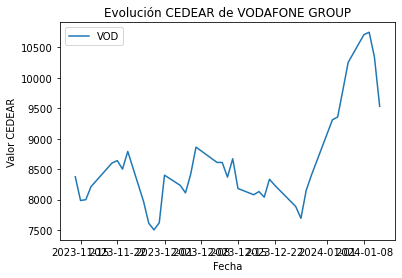

In [11]:
# Graficamos la evolución de los CEDEAR consultados:
cedear = list(df_consulta['nombre_cedear'].unique())
for i in range(len(cedear)):
    df_unico = df_consulta[df_consulta['nombre_cedear'] == cedear[i]]
    x = list(df_consulta['fecha'].unique())
    y = list(df_unico['cierre'])
    plt.plot(x, y, label = cedear[i])

plt.title(f"Evolución CEDEAR de {empresa}")
plt.xlabel("Fecha")
plt.ylabel("Valor CEDEAR")
plt.legend()
plt.show()

---
**CONSULTA 2:** Consultar la evolución de un CEDEAR particular:

In [17]:
# Ver listado completo de CEDEAR disponibles:
#comando = "SELECT (nombre_cedear) FROM cedear;"
#list(pd.read_sql(comando, connection)['nombre_cedear'])

In [12]:
# Datos de sugerencia: "abnb", "adi", "coin", "lvs".
cedear = input("Ingrese las siglas del CEDEAR: ").upper()
comando = "SELECT (id_cedear) FROM cedear WHERE nombre_cedear = '"+cedear+"';"
id_cedear = list(pd.read_sql(comando, connection)['id_cedear'])[0]
comando = "SELECT nombre_empresa, id_cedear, nombre_cedear, apertura, minimo, maximo, cierre, monto_operado, fecha FROM empresas INNER JOIN cedear ON cedear.indice_empresa = empresas.id_empresa INNER JOIN registros ON registros.indice_cedear = cedear.id_cedear WHERE id_cedear = '"+str(id_cedear)+"';"
df_consulta = pd.read_sql(comando, connection)
df_consulta

Ingrese las siglas del CEDEAR: glob


,nombre_empresa,id_cedear,nombre_cedear,apertura,minimo,maximo,cierre,monto_operado,fecha
0,GLOBANT,127,GLOB,8425.5,8425.5,8943.5,8425.5,52125013.0,2023-11-14
1,GLOBANT,127,GLOB,8790.0,8790.0,9137.0,8770.5,140019525.0,2023-11-15
2,GLOBANT,127,GLOB,9200.0,8850.0,9600.0,8863.0,131314476.0,2023-11-16
3,GLOBANT,127,GLOB,9110.0,9110.0,9864.0,9772.5,226829585.0,2023-11-17
4,GLOBANT,127,GLOB,10417.0,9900.0,10420.0,10167.0,126061749.0,2023-11-21
5,GLOBANT,127,GLOB,10170.0,10000.0,11332.0,11176.0,209061969.0,2023-11-22
6,GLOBANT,127,GLOB,11176.0,11050.0,11580.0,11381.5,29986200.0,2023-11-23
7,GLOBANT,127,GLOB,11400.0,10400.0,11699.0,10816.0,61337594.0,2023-11-24
8,GLOBANT,127,GLOB,10824.0,9869.0,11100.0,10284.0,115812845.0,2023-11-27
9,GLOBANT,127,GLOB,10300.0,9600.0,10498.0,9976.0,69667069.0,2023-11-28


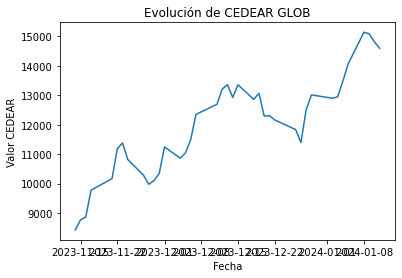

In [13]:
# Graficamos la evolución del CEDEAR consultado:
plt.plot(df_consulta['fecha'], df_consulta['cierre'])
plt.title(f"Evolución de CEDEAR {cedear}")
plt.xlabel("Fecha")
plt.ylabel("Valor CEDEAR")
plt.show()

---

**CONSULTA 3:** Consultar los 10 CEDEAR de mayor crecimiento en un período dado:

In [14]:
# Leemos todos los registros guardados:
comando = "SELECT * FROM registros;"
df_consulta = pd.read_sql(comando, connection)

# Consultamos la fecha más antigua y la más actual:
fecha_min_reg = df_consulta['fecha'].min()
fecha_max_reg = df_consulta['fecha'].max()

# Solicitamos el período requerido:
print("Ingrese la fecha inicial y final del período requerido en formato 'AAAA-MM-DD'")
print(f"Período máximo disponible: {fecha_min_reg} al {fecha_max_reg}")
fecha_min = input("Ingrese la fecha inicial: ") or fecha_min_reg
fecha_max = input("Ingrese la fecha final: ") or fecha_max_reg

# Segregamos los datos en 2 dataframes discriminados por fecha:
df_1 = df_consulta[df_consulta['fecha'] == pd.to_datetime(fecha_min)]
df_2 = df_consulta[df_consulta['fecha'] == pd.to_datetime(fecha_max)]

# Calculamos la diferencia entre valores de cierre antíguo y actual:
df_2['crecimiento'] = df_2['cierre'].values - df_1['cierre'].values

# Los ordenamos de forma descendente y tomamos los 'indice_cedear' de los 10 primeros elementos:
df_2.sort_values('crecimiento', ascending=False, inplace=True)
id_cedear = list(df_2.head(10)['indice_cedear'])

# Realizamos la consulta:
df_consulta = pd.DataFrame()
for i in range(len(id_cedear)):
    comando = "SELECT nombre_empresa, id_cedear, nombre_cedear FROM empresas INNER JOIN cedear ON cedear.indice_empresa = empresas.id_empresa WHERE id_cedear = '"+str(id_cedear[i])+"';"
    df_top = pd.read_sql(comando, connection)
    df_consulta = pd.concat([df_consulta, df_top])

# Añadimos el dato del crecimiento:
df_consulta['crecimiento'] = df_2.head(10)['crecimiento'].values
df_consulta

Ingrese la fecha inicial y final del período requerido en formato 'AAAA-MM-DD'
Período máximo disponible: 2023-11-14 al 2024-01-11
Ingrese la fecha inicial: 
Ingrese la fecha final: 


,nombre_empresa,id_cedear,nombre_cedear,crecimiento
0,HUT 8 MINING CORP.,154,HUT,62079.00
0,CORPORACIÓN AMÉRICA AIRPORTS S.A.,69,CAAP,35259.00
0,ELI LILLY,178,LLY,24574.13
0,FIRST SOLAR,119,FSLR,23155.00
0,HOWMET AEROSPACE,155,HWM,19808.00
0,SOUTHERN COPPER,261,SCCO,18282.00
0,"UBER TECHNOLOGIES, INC.",308,UBER,16092.00
0,COMPANHIA SIDERÚRGICA NACIONAL,267,SID,15723.50
0,SNAP-ON,270,SNA,15085.00
0,NATIONAL GRID,213,NGG,15029.50


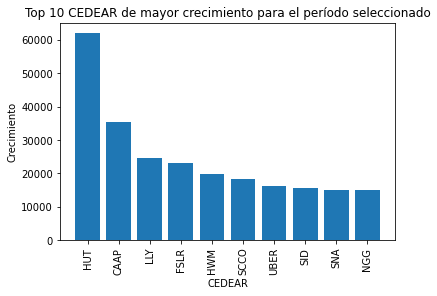

In [15]:
# Graficamos los resultados:
plt.bar(df_consulta['nombre_cedear'], df_consulta['crecimiento'])
plt.title("Top 10 CEDEAR de mayor crecimiento para el período seleccionado")
plt.xlabel("CEDEAR")
plt.ylabel("Crecimiento")
plt.xticks(range(len(list(df_consulta['nombre_cedear']))), df_consulta['nombre_cedear'], rotation='vertical')
plt.show()